# Analyze A/B Test Results 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion and Suggestions](#Conclusion)


<a id='intro'></a>
## Introduction

This project is about the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#setting the seed to assure we get the same answers on quizzes 
random.seed(42)

### 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [3]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**c.** The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
df.query("(group == 'treatment' and landing_page == 'old_page')").shape[0]

1965

In [8]:
#df.query('(group=="treatment"& landing_page!="new_page")|(group=="control"& landing_page!="old_page")')

**f.** Do any of the rows have missing values?

In [9]:
df.isnull().any(axis=1).mean()

0.0

### 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


We should remove the rows where the group and landing_page columns don't match. we should only use the rows that we can feel confident in the accuracy of the data.

**a.** Now create a new dataset and store the new dataframe in **df2**.

In [10]:
df3=df.query('(group=="treatment"& landing_page!="new_page")|(group=="control"& landing_page!="old_page")')

In [11]:
index=df3.index

In [12]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2=df.drop(index,axis=0)

In [13]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

###  1.3  

**a.** How many unique **user_id**s are in **df2**?

In [14]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [15]:
df2[df2.user_id.duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [16]:
df2.query('user_id==773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [17]:
# Remove one of the rows with a duplicate user_id.
df2=df2.drop(index = 2893, axis = 0)

# Check again if the row with a duplicate user_id is deleted or not

In [18]:
df2.user_id.duplicated().sum()

0

In [19]:
df2[df2.user_id.duplicated()==True]

,user_id,timestamp,group,landing_page,converted


In [20]:
df2.query('user_id==773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


### 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

>The probability $p_{population}$ is to compute represents the overall "converted" success rate in the population .



In [22]:
P_population=df2.converted.mean()
P_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [23]:
df2.query('group=="control"').converted.mean()

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [24]:
df2.query('group=="treatment"').converted.mean()

0.11880806551510564

>The probabilities computed in the points (b). and (c). above can also be treated as conversion rate. 
Now we Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. 

In [25]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff=df2.query('group=="treatment"').converted.mean()-df2.query('group=="control"').converted.mean()
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [26]:
df4=df2.query('landing_page=="new_page"')
df4.shape[0]/df2.shape[0]

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

The probability that an individual received the new page is around 0.5;

**The "converted" probability (or rate) for the old page is *slightly* higher than that of the new page.**

The actual difference (obs_diff) between the conversion rates for the two groups is around 0.15%.   

**So the new treatment group users doesn't lead to more conversions.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, we could run a hypothesis test continuously as long as we observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do we run to render a decision that neither page is better than another?  



###  2.1

> we just calculated that the "converted" probability (or rate) for the old page(1.4.b) is *slightly* higher than that of the new page (1.4.c). 

Assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%

**$p_{old}$** is the "converted" probability (or rate) for the old pages.

**$p_{new}$** is the "converted" probability (or rate) for the new pages.

- H_0: new page has no positive effect on conversion rate 
$$ p_{new}-p_{old}  <= 0$$
- H_1: new page has positive effect on conversion rate 
$$ p_{new}-p_{old}  > 0$$

###  2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [27]:
df2.converted.mean()

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [28]:
df2.converted.mean()

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [29]:
df2.query('landing_page=="new_page"').shape

(145310, 5)

**d.** What is $n_{old}$, the number of individuals in the control group?

In [30]:
df2.query('landing_page=="old_page"').shape

(145274, 5)

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [31]:
size_n =df2.query('group=="treatment"').shape[0]

In [32]:
new_page_converted = np.random.choice([0, 1], size_n, p=[0.5, 0.5])

In [33]:
new_page_converted

array([0, 1, 1, ..., 0, 0, 1])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [34]:
size_o =df2.query('group=="treatment"').shape[0]
old_page_converted = np.random.choice([0, 1], size_o, p=[0.5, 0.5])
old_page_converted

array([1, 0, 0, ..., 1, 1, 1])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [35]:
new_page_converted.mean()-old_page_converted.mean()

-0.0032688734429839883


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [36]:
new_means, old_means, p_diffs = [], [], []
p_new=0.5
p_old=0.5

for _ in range(10000):
    new_converted_simulation = np.random.binomial(size_n, p_new, 10000)/size_n
    old_converted_simulation = np.random.binomial(size_o, p_old, 10000)/size_o
    p_diffs = new_converted_simulation - old_converted_simulation

In [37]:
'''
new_means, old_means, p_diffs = [], [], []

for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size_n, p=[0.5, 0.5])
    old_page_converted = np.random.choice([0, 1], size_o, p=[0.5, 0.5])
    new_mean =new_page_converted.mean()
    old_mean =old_page_converted.mean()
    # append the info 
    old_means.append(old_mean)
    new_means.append(new_mean)
    p_diffs.append(new_mean - old_mean)   
 '''

'\nnew_means, old_means, p_diffs = [], [], []\n\nfor _ in range(10000):\n    new_page_converted = np.random.choice([0, 1], size_n, p=[0.5, 0.5])\n    old_page_converted = np.random.choice([0, 1], size_o, p=[0.5, 0.5])\n    new_mean =new_page_converted.mean()\n    old_mean =old_page_converted.mean()\n    # append the info \n    old_means.append(old_mean)\n    new_means.append(new_mean)\n    p_diffs.append(new_mean - old_mean)   \n '

In [38]:
# Sampling distribution 
p_diffs 

array([  6.88183883e-06,  -5.29901590e-04,   2.30541601e-03, ...,
        -2.47746198e-03,   4.32179478e-03,   5.78074461e-04])

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.   <br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

Text(0.5,1,'distribution of p_diff')

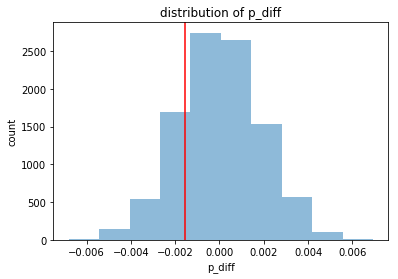

In [39]:
plt.hist(p_diffs, alpha = 0.5);
plt.axvline(obs_diff, c='red')
plt.xlabel('p_diff')
plt.ylabel('count')
plt.title('distribution of p_diff')

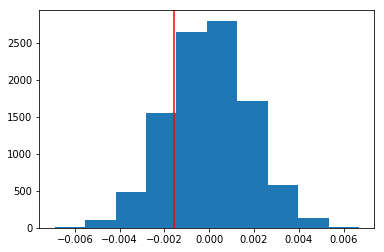

In [40]:
# Convert to numpy array
diffs = np.array(p_diffs)
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

# Plot observed statistic with the null distibution
plt.hist(null_vals);
plt.axvline(obs_diff, c='red')

In [41]:
sample_mean=obs_diff
sample_mean

-0.0015782389853555567

In [42]:
# Compute p-value
null_mean=null_vals.mean()
p_value=(null_vals<sample_mean).mean()
p_value

0.19670000000000001

p-value should be **right tail** of the histogram

large p-value suggests that we should not move away from the null Hypothese.

pval>α⇒ Fail to Reject H_0 ⇒ we accept H_0

P-value 0.1923 > "Type I error rate" 0.05. We fail to reject the null hypothesis, which means new page has **no** positive effect on conversion rate

**j.** What proportion of the **p_diffs** (Sampling distribution )are greater than the actual difference observed in the `df2` data?

In [43]:
1-p_value

0.80330000000000001

**k.** Explaination of the value computed in part **j** above.  
 - 1-p_value=0.80769999999999997
 - It means the probability of observing the statistic if the null hypothesis is true. 
 - Conclusion: There is more than 80% possibility of observing the statistic when new page has no positive effect on conversion rate



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  

the statements below :
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [44]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('group=="control"').converted.mean()

# number of conversions with the new_page
convert_new = df2.query('group=="treatment"').converted.mean()

# number of individuals who were shown the old_page
n_old = df2.query('group=="control"').shape[0]

# number of individuals who received new_page
n_new = df2.query('group=="treatment"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**m.** Now use `sm.stats.proportions_ztest()` to compute the test statistic and p-value.  

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
> <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 




---
In this case, we know that it's a **right-tailed** since I defined $H_1$ as $(p_{new} > p_{old})$.

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

><br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---
In this case, it's a right-tailed test, so we reject null if $Z_{score}$ > $Z_{\alpha}$=1.645. <br>

In [45]:
import statsmodels.api as sm
count_array=[convert_old,convert_new]
nobs_array=[n_old,n_new]
z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative='larger')
print(z_score, p_value)

0.00328757967535 0.49868844783


**n.** What do the z-score and p-value mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>
$Z_{0.05}$ is 1.645 for one-tailed test.

>  $Z_{score}$=0.00328757967535 < $Z_{\alpha}$    <br>
    we fail to reject the null hypothesis,  we accept null hypothesis, which means new page has **no** positive effect on conversion rate
    
> p-value=0.49868844783 is the probability of observing the statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.<br>
This p-value means the possibility that the new page cause positive effect is nearly 0.5 under the situation that new page has **no** positive effect on conversion rate

> p-value>0.05, fail to reject null<br>

>z-score and p-value agree with the findings in parts **j.** and **k.**

<a id='regression'></a>
### Part III - A regression approach

###  3.1 
In this final part, we will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, the type of regression performing in this case should be:

>**Logistic regression**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [46]:
landing_page_dummies = pd.get_dummies(df2['landing_page'])
df_new = df2.join(landing_page_dummies)
df_new['ab_page']=df_new['new_page']

df_new['intercept'] = 1

In [47]:
df_new.head()

,user_id,timestamp,group,landing_page,converted,new_page,old_page,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,0,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [48]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below.

In [49]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-02-12 21:14 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


>The p-value associated with ab_page is 0.1899

>It differs from the value in Part II. Because it reflects the relationship between the conversion rate and if the type of the web page is new page.

>Null hypothes associated with the regression model: the conversion rate is related to the fact that if the webpage is a new page.<br>
Alternative hypothes: the conversion rate is not related to the fact that if the webpage is a new page.

>**Comparision**: In this hypothese only consider the relationship between new web page and conversion rate. Old page is not analysed as in **Part II**

> The p-values are two-sided in a binary logistic regression but one-sided in **Part II**<br>
> The current p-value=0.1899 is larger than the Type I error rate (0.05).<br>
The current p-value suggest new_page is **not** statistically significant for conversion rate.



**f.** Now, considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>As is show above, new page is not statistically significant for conversion rate, so considering other factors may build a more accurate model. <br>But the advantage is that the model will not fit the data if the additional term doesn't describe the data very well.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. We will need to read in the **countries.csv** dataset and merge together the `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. 
2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


In [50]:
# Read the countries.csv
df_countries=pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [51]:
# Join with the df2 dataframe
df_merged=df_new.set_index('user_id').join(df_countries.set_index('user_id'))
df_merged.head()

,timestamp,group,landing_page,converted,new_page,old_page,ab_page,intercept,country
user_id,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,0,1,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,0,1,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,0,1,US


In [52]:
df_merged.query('user_id==834778')

,timestamp,group,landing_page,converted,new_page,old_page,ab_page,intercept,country
user_id,,,,,,,,,
834778,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,UK


In [53]:
# Create the necessary dummy variables
country_dummies = pd.get_dummies(df_merged['country'])
df_g = df_merged.join(country_dummies)
df_g.head()

,timestamp,group,landing_page,converted,new_page,old_page,ab_page,intercept,country,CA,UK,US
user_id,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,0,1,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,0,1,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,0,1,US,0,0,1


**h. Fit the model and obtain the results**<br> 
Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  




In [54]:
# Fit the model, and summarize the results
df_g['intercept'] = 1
log_mod2 = sm.Logit(df_g['converted'], df_g[['intercept', 'ab_page', 'CA', 'UK']])
results2 = log_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-02-12 21:14 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [55]:
np.exp(-0.0149),np.exp(-0.0408),np.exp(0.0099)

(0.9852104557227469, 0.96002111497165088, 1.0099491671175422)

In [57]:
1/np.exp(-0.0149),1/np.exp(-0.0408),1/np.exp(0.0099)

(1.0150115583846535, 1.0416437559600236, 0.99014884368295708)

**i. Summary results (statistical output), and conclusions (written response) based on the results**<br> 
- p-value of new_page is 0.1912; p-value of CA is 0.1295; p-value of UK is 0.4573  and they are all larger than the Type I error rate (0.05). 
- So we fail to reject the null hypotheses (regression model)
- the effect of page and country to predict the conversion:



>For each unit of new page, conversion is 0.99 times as likely than old page, holding all other variables constant.

>Conversion in CA is 0.96 times as likely than US, holding all other variables (duration) constant.

>Conversion in UK is 1.01 times as likely than US, holding all other variables (duration) constant.

<a id='Conclusion'></a>
## Conclusion and Suggestions


Finally I would suggest that the company keep the old page since the new page doesn't have positive effect on conversion rate at 95% confidence interval.<br>  

From the analysis, it also can be seen that the country can be a factor which influence the conversion rate. So the company can design more investigation on conversion rate on  different customers from different countries.<br> 

In [56]:
#from subprocess import call
#call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])